# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([16,17,18,19,20])  # new_rides.hour.unique()
prices_ = np.array([0,5,10,15])# np.array([5*(i) for i in range(5)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.66s/it]


# Configurations

In [3]:
x = [17,2]  # [time, distance]
g_uber = np.sum(g[np.where(cab_types_=='Uber'),:,:,np.where(distances_==x[1])], axis=3).reshape((-1,1))
g_lyft = np.sum(g[np.where(cab_types_=='Lyft'),:,:,np.where(distances_==x[1])], axis=3).reshape((-1,1))

prices_ = prices_.reshape((-1,1))

print(f'g_uber = \n{g_uber}')
print(f'g_lyft = \n{g_lyft}')

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1e0
lambda_p2 = 1e0

eta_p1 = 1e-2
eta_p2 = 1e-2

mu_p1 = -0.07*g_uber
gamma_p1 = 0.02*g_uber
mu_p2 = -0.07*g_lyft
gamma_p2 = 0.02*g_lyft

print(f'mu_1 = \n{mu_p1}')
print(f'gamma_1 = \n{gamma_p1}')
print(f'mu_2 = \n{mu_p2}')
print(f'gamma_2 = \n{gamma_p2}')

g_uber = 
[[1.76470588e-01]
 [5.96764706e+02]
 [2.59117647e+02]
 [2.52529412e+02]]
g_lyft = 
[[ 63.58823529]
 [355.17647059]
 [372.94117647]
 [257.82352941]]
mu_1 = 
[[-1.23529412e-02]
 [-4.17735294e+01]
 [-1.81382353e+01]
 [-1.76770588e+01]]
gamma_1 = 
[[3.52941176e-03]
 [1.19352941e+01]
 [5.18235294e+00]
 [5.05058824e+00]]
mu_2 = 
[[ -4.45117647]
 [-24.86235294]
 [-26.10588235]
 [-18.04764706]]
gamma_2 = 
[[1.27176471]
 [7.10352941]
 [7.45882353]
 [5.15647059]]


In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(1,5,5,dtype='int')
num_test = 1000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [6]:
np.random.seed(0)
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_samples in num_rounds_lst:
    print(f"num_samples = {num_samples}")
    rounds_1 = max(math.floor(0.8*num_samples),num_samples-1000)
    rounds_2 = num_samples-rounds_1
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds=rounds_1, num_alternate_rounds=rounds_2, num_test=1000)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_samples = 10
---------------------
Player 1: mu error
18.161382322969995
Player 1: gamma error
33.56925480047968
Player 1 Risk:
-9153.052294448406
Player 2: mu error
51.27116790873877
Player 2: gamma error
74.3664001151023
Player 2 Risk:
-9259.989449953693
---------------------
num_samples = 100
---------------------
Player 1: mu error
9.110613272766766
Player 1: gamma error
9.926588191336366
Player 1 Risk:
-11185.614004061295
Player 2: mu error
5.263857649275335
Player 2: gamma error
5.323642575876061
Player 2 Risk:
-10739.937165375248
---------------------
num_samples = 1000
---------------------
Player 1: mu error
1.0150873192160719
Player 1: gamma error
1.291067685343051
Player 1 Risk:
-11048.649190350843
Player 2: mu error
0.564560637358204
Player 2: gamma error
1.9166240898695859
Player 2 Risk:
-10752.022371522751
---------------------
num_samples = 10000
---------------------
Player 1: mu error
0.7108574844047408
Player 1: gamma error
0.17171611518290775
Player 1 Risk:
-1104

# Run game with DFO players

In [7]:
np.random.seed(0)
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 4e-1
eta = 1e-1
num_test_dfo = 100
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test = num_test_dfo)

# print(game_dfo.theta_p1)

for i in trange(math.ceil(num_rounds/2/num_test_dfo)+1):

    theta31, theta32 = player_three.perturb_theta()
    theta41, theta42 = player_four.perturb_theta()
    
    game_dfo.theta_p1 = theta31
    game_dfo.theta_p2 = theta41
    pr31 = game_dfo.evaluate_perf_risk_p1()
    pr41 = game_dfo.evaluate_perf_risk_p2()
    
    game_dfo.theta_p1 = theta32
    game_dfo.theta_p2 = theta42
    pr32 = game_dfo.evaluate_perf_risk_p1()
    pr42 = game_dfo.evaluate_perf_risk_p2()
#     print(pr31)
#     print(pr32)
    
    game_dfo.theta_p1 = player_three.update_theta(pr31, pr32)
    game_dfo.theta_p2 = player_four.update_theta(pr41, pr42)
#     print(game_dfo.theta_p1)
    
    if i*2*num_test_dfo >= num_rounds_lst[len(p3_risks)]:
#         p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
#                                                    mu_p1, gamma_p1,
#                                                    lambda_p1,
#                                                    game_dfo.theta_p1, game_dfo.theta_p2,
#                                                    num_test))
#         p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
#                                                    mu_p2, gamma_p2,
#                                                    lambda_p2,
#                                                    game_dfo.theta_p2, game_dfo.theta_p1,
#                                                    num_test))
        p3_risks.append(np.mean(np.array(game_dfo.p1.risk_history[max(-i,-1000)])))
        p4_risks.append(np.mean(np.array(game_dfo.p2.risk_history[max(-i,-1000)])))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if False:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 1110.74it/s]


## Plots

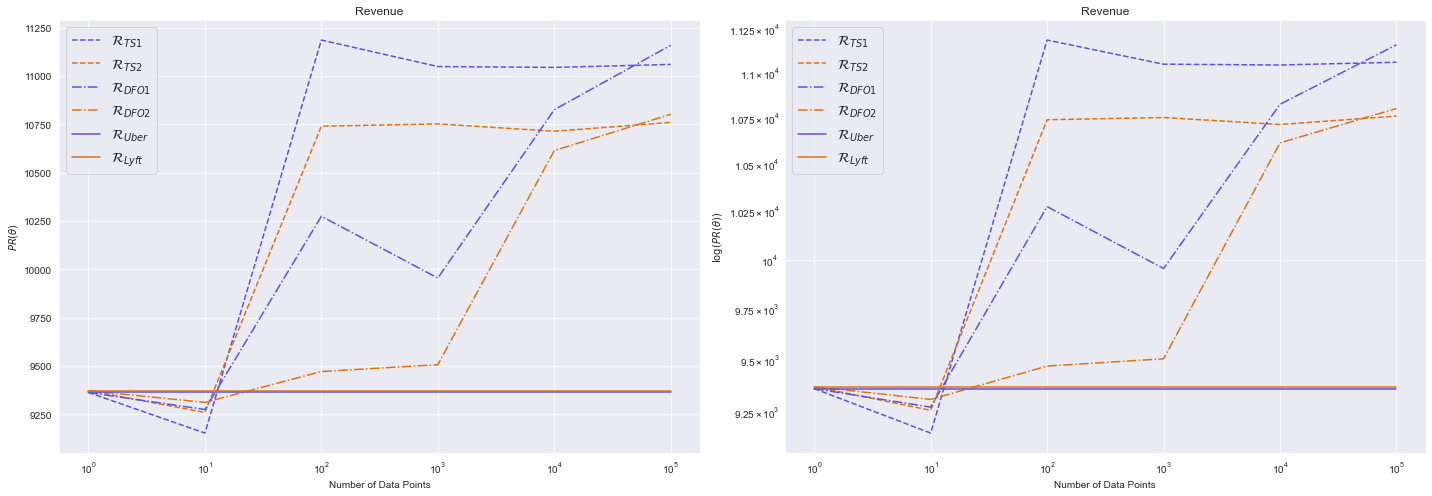

In [8]:
base_uber = -np.dot(g_uber.T,prices_)[0,0]
base_lyft = -np.dot(g_lyft.T,prices_)[0,0]

num_rounds_lst_ = np.insert(num_rounds_lst,0,1)
p1_risks.insert(0,base_uber)
p2_risks.insert(0,base_lyft)
p3_risks.insert(0,base_uber)
p4_risks.insert(0,base_lyft)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst_, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst_, -np.squeeze(p3_risks),
             '-.', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst_, -np.squeeze(p4_risks),
             '-.', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.semilogx(num_rounds_lst_, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.semilogx(num_rounds_lst_, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst_, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst_, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst_, -np.squeeze(p3_risks),
             '-.', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst_, -np.squeeze(p4_risks),
             '-.', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.loglog(num_rounds_lst_, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.loglog(num_rounds_lst_, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst_))],
             '-', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
# plt.xlabel("Number of Data Points")
# plt.ylabel(r"$\log(PR(\theta))$")
# plt.title('Strategies')
# plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

In [9]:
print(f'theta_1_ts - theta_1_dfo = \n{game_ts.theta_p1-game_dfo.theta_p1}')
print(f'theta_2_ts - theta_2_dfo = \n{game_ts.theta_p2-game_dfo.theta_p2}')

theta_1_ts - theta_1_dfo = 
[[ 1.31826109]
 [ 0.08408327]
 [-0.75522647]
 [ 0.45394152]]
theta_2_ts - theta_2_dfo = 
[[ 0.44531979]
 [ 0.00245234]
 [-1.00460983]
 [-0.41356089]]


In [10]:
print(f'theta_1_ts = \n{game_ts.theta_p1}')
print(f'theta_2_ts = \n{game_ts.theta_p2}')

theta_1_ts = 
[[ 0.47701988]
 [ 5.        ]
 [ 2.47882616]
 [-0.38091587]]
theta_2_ts = 
[[ 5.        ]
 [ 5.        ]
 [ 2.39869733]
 [-0.44876221]]


In [11]:
print(f'theta_1_dfo = \n{game_dfo.theta_p1}')
print(f'theta_2_dfo = \n{game_dfo.theta_p2}')

theta_1_dfo = 
[[-0.84124121]
 [ 4.91591673]
 [ 3.23405263]
 [-0.83485739]]
theta_2_dfo = 
[[ 4.55468021]
 [ 4.99754766]
 [ 3.40330715]
 [-0.03520133]]


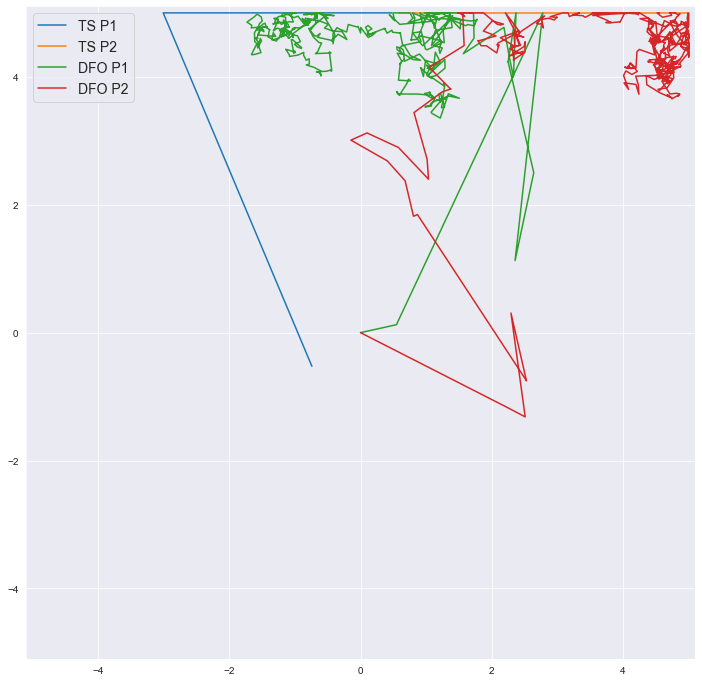

In [12]:
plt.figure(figsize=(12,12))
plt.plot(np.array(theta_final_p1)[:,0].squeeze(),
         np.array(theta_final_p1)[:,1].squeeze(), label='TS P1')
plt.plot(np.array(theta_final_p2)[:,0].squeeze(),
         np.array(theta_final_p2)[:,1].squeeze(), label='TS P2')
plt.plot(np.array(game_dfo.p1.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p1.theta_history)[:,1].squeeze(), label='DFO P1')
plt.plot(np.array(game_dfo.p2.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p2.theta_history)[:,1].squeeze(), label='DFO P2')
plt.xlim(-5.1,5.1)
plt.ylim(-5.1,5.1)
plt.legend(fontsize=14)
plt.savefig('DD_regression_rideshare_trajectory.jpg', format='jpg')
plt.show()

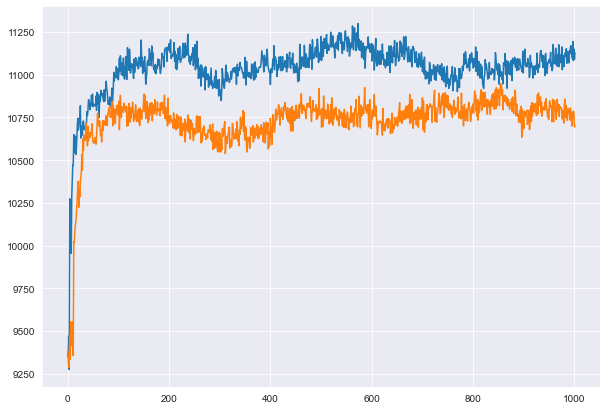

In [13]:
plt.figure(figsize=(10,7))
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

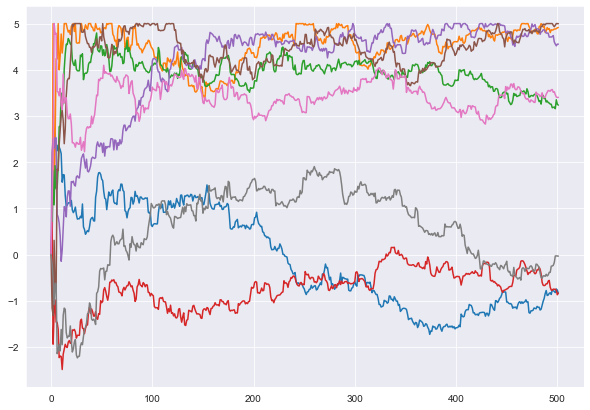

In [14]:
plt.figure(figsize=(10,7))
plt.plot(np.squeeze(game_dfo.p1.theta_history))
plt.plot(np.squeeze(game_dfo.p2.theta_history))
plt.show()